## Lecture 4 — Data (BCRP + Yahoo) + Plots + Stats + VaR

Reproduce the key parts of the lecture notebook using:

- **Peru (BCRP API)**: `PD04637PD`, `PD04639PD`, `PD04704XD`, `PD04701XD`  
  *(FX + commodities exactly as in the notebook)*
- **USA (yfinance)**: `SPY`, `TLT`, `GLD`

**Deliverables**
- Multiple **plots** (including **one with annotations**)  
- A **summary statistics table**  
- **Historical 95% VaR** for a **60/40 portfolio** (SPY/TLT)

1. Build (and display) the **BCRPData API URL** that requests the 4 series used in the notebook.  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import requests
from datetime import datetime

In [ ]:
# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# --- Ejercicio 1: Construir URL API BCRP ---
# Códigos: Interbancario (PD04637PD), SBS (PD04639PD), Oro (PD04704XD), Cobre (PD04701XD)
base_url = "https://estadisticas.bcrp.gob.pe/estadisticas/series/api"
codigos = "PD04637PD-PD04639PD-PD04704XD-PD04701XD"
fmt = "json"
start_date = "2020-01-01"
end_date = "2023-12-31"

url = f"{base_url}/{codigos}/{fmt}/{start_date}/{end_date}"
print(f"URL Generada: {url}")

URL Generada: https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/json/2020-01-01/2023-12-31


2. Download those series and build a **tidy** table: `date`, `series`, `value`.  


In [ ]:
# Ejercicio 2
response = requests.get(url)
data = response.json()

periods = data['periods']
records = []

for period in periods:
    fecha = period['name']
    values = period['values']

    # Función rápida para convertir "n.d." a None (vacío)
    def clean_val(x):
        return float(x) if x != 'n.d.' else None

    # Mapeamos usando la función segura
    records.append({'date': fecha, 'series': 'fx_interbank', 'value': clean_val(values[0])})
    records.append({'date': fecha, 'series': 'fx_sbs',       'value': clean_val(values[1])})
    records.append({'date': fecha, 'series': 'gold',         'value': clean_val(values[2])})
    records.append({'date': fecha, 'series': 'copper',       'value': clean_val(values[3])})

df_bcrp_tidy = pd.DataFrame(records)
# Eliminamos las filas vacías (días feriados)
df_bcrp_tidy = df_bcrp_tidy.dropna()

print("Datos descargados y procesados correctamente.")

Datos descargados y procesados correctamente.


3. Clean to **wide format** with columns: `fx_interbank`, `fx_sbs`, `gold`, `copper` (as in the notebook).  


In [ ]:
# --- Ejercicio 3: Pasar a formato Wide y Corregir Fechas ---

# 1. Hacemos el pivot (igual que antes)
df_bcrp = df_bcrp_tidy.pivot(index='date', columns='series', values='value')

# 2. Diccionario para traducir meses: Español BCRP -> Inglés Python
traductor_meses = {
    'Ene': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'Abr': 'Apr',
    'May': 'May', 'Jun': 'Jun', 'Jul': 'Jul', 'Ago': 'Aug',
    'Set': 'Sep', 'Oct': 'Oct', 'Nov': 'Nov', 'Dic': 'Dec'
}

# 3. Función para reemplazar el texto de la fecha
def arreglar_fecha(fecha_str):
    for mes_es, mes_en in traductor_meses.items():
        if mes_es in fecha_str:
            return fecha_str.replace(mes_es, mes_en)
    return fecha_str

# 4. Aplicamos la corrección y convertimos
# Primero traducimos (ej: "02.Ene.23" -> "02.Jan.23")
df_bcrp.index = df_bcrp.index.map(arreglar_fecha)

# Ahora sí convertimos a formato fecha (Día.Mes.Año)
df_bcrp.index = pd.to_datetime(df_bcrp.index, format="%d.%b.%y")
df_bcrp = df_bcrp.sort_index()

print("Datos BCRP cargados y fechas corregidas:")
print(df_bcrp.head())

Datos BCRP cargados y fechas corregidas:
series       copper  fx_interbank  fx_sbs        gold
date                                                 
2020-01-01  1523.00           NaN     NaN  278.913951
2020-01-02  1527.10      3.301000   3.301  279.571660
2020-01-03  1548.75      3.310571   3.308  276.872785
2020-01-06  1573.10      3.322000   3.320  277.349057
2020-01-07  1567.85      3.325571   3.325  277.938727


4. Download `SPY`, `TLT`, `GLD` from yfinance and build: `date`, `ticker`, `close`.  


In [ ]:
# --- Ejercicio 4: Descargar SPY, TLT, GLD ---
tickers = ['SPY', 'TLT', 'GLD']
df_yahoo = yf.download(tickers, start="2020-01-01", end="2023-12-31")['Close']

print("Datos de Yahoo descargados correctamente.")
print(df_yahoo.head())

/tmp/ipython-input-3932127195.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_yahoo = yf.download(tickers, start="2020-01-01", end="2023-12-31")['Close']
[*********************100%***********************]  3 of 3 completed

Datos de Yahoo descargados correctamente.
Ticker             GLD         SPY         TLT
Date                                          
2020-01-02  143.949997  297.699005  115.443695
2020-01-03  145.860001  295.444824  117.221581
2020-01-06  147.389999  296.571899  116.555923
2020-01-07  147.970001  295.738007  115.982956
2020-01-08  146.860001  297.314148  115.216225


5. Compute **daily returns** by ticker (`ret`) and validate there are **no inf values**.  


In [ ]:
# --- Ejercicio 5: Calcular retornos diarios ---
returns = df_yahoo.pct_change().dropna()

# Validar que no hay infinitos
if not np.isinf(returns).values.any():
    print("No hay valores infinitos en los retornos.")

No hay valores infinitos en los retornos.


6. *(Quantities)* Compare FX levels in Peru: produce a **plot** and a short comment.  


7. *(Proportions)* Compute the **share of positive-return days** by ticker (USA).  


8. Plot that share as a **bar chart** and add **labels above each bar** (`annotate`).  


9. *(Distributions)* Compare the distribution of **Peru Gold** vs **GLD** (histogram).  


10. Add an **ECDF** (if used in the notebook) and comment on what changes vs the histogram.  


11. *(Relationships)* Build `FX_change` and relate it to `SPY_ret` (scatter plot).  



EJERCICIO 11: Relación entre FX_change y SPY_ret


/tmp/ipython-input-1503042147.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_bcrp['fx_change'] = df_bcrp['fx_interbank'].pct_change()


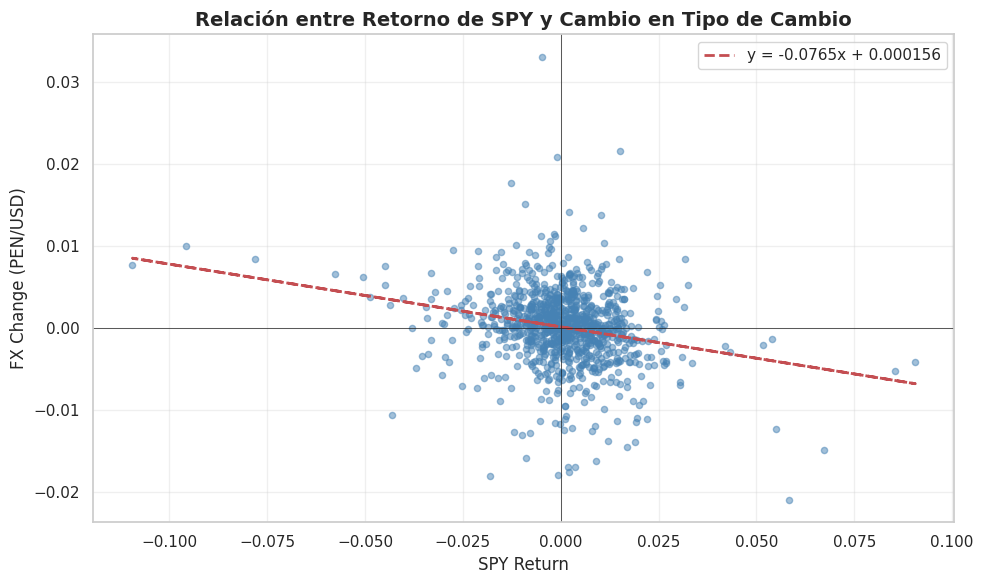


📈 Número de observaciones: 1003


In [ ]:
print("\n" + "="*70)
print("EJERCICIO 11: Relación entre FX_change y SPY_ret")
print("="*70)

# Calcular cambio en tipo de cambio
df_bcrp['fx_change'] = df_bcrp['fx_interbank'].pct_change()

# Combinar con retornos de SPY
df_analysis = pd.merge(
    df_bcrp[['fx_change']].dropna(),
    returns[['SPY']],
    left_index=True,
    right_index=True,
    how='inner'
)
df_analysis.columns = ['fx_change', 'spy_ret']

# Crear scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_analysis['spy_ret'], df_analysis['fx_change'],
            alpha=0.5, s=20, color='steelblue')

# Añadir línea de regresión
z = np.polyfit(df_analysis['spy_ret'], df_analysis['fx_change'], 1)
p = np.poly1d(z)
plt.plot(df_analysis['spy_ret'], p(df_analysis['spy_ret']),
         "r--", linewidth=2, label=f'y = {z[0]:.4f}x + {z[1]:.6f}')

plt.xlabel('SPY Return', fontsize=12)
plt.ylabel('FX Change (PEN/USD)', fontsize=12)
plt.title('Relación entre Retorno de SPY y Cambio en Tipo de Cambio',
          fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)
plt.tight_layout()
plt.show()

print(f"\n📈 Número de observaciones: {len(df_analysis)}")

12. Compute the **correlation** between `FX_change` and `SPY_ret` and explain the sign.  



EJERCICIO 12: Correlación FX_change vs SPY_ret

📊 Correlación: -0.2329

🔍 INTERPRETACIÓN DEL SIGNO:
----------------------------------------------------------------------
✓ CORRELACIÓN NEGATIVA

¿Por qué?
  1. Cuando SPY sube (mercado USA fuerte):
     → Más apetito por activos de riesgo
     → Dólar se fortalece (divisa refugio)
     → PEN/USD baja (se necesitan menos soles por dólar)
     → fx_change es NEGATIVO

  2. Cuando SPY baja (mercado USA débil):
     → Huida hacia seguridad
     → Dólar se fortalece aún más
     → PEN/USD sube
     → fx_change es POSITIVO

  3. Flight to Safety:
     → En crisis, todos buscan USD
     → Monedas emergentes (PEN) se deprecian


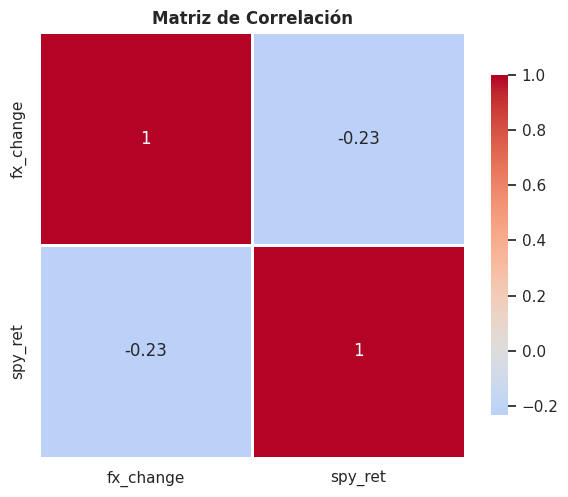

In [ ]:
print("\n" + "="*70)
print("EJERCICIO 12: Correlación FX_change vs SPY_ret")
print("="*70)

# Calcular correlación
correlation = df_analysis['fx_change'].corr(df_analysis['spy_ret'])

print(f"\n📊 Correlación: {correlation:.4f}")
print("\n🔍 INTERPRETACIÓN DEL SIGNO:")
print("-" * 70)

if correlation < 0:
    print("✓ CORRELACIÓN NEGATIVA")
    print("\n¿Por qué?")
    print("  1. Cuando SPY sube (mercado USA fuerte):")
    print("     → Más apetito por activos de riesgo")
    print("     → Dólar se fortalece (divisa refugio)")
    print("     → PEN/USD baja (se necesitan menos soles por dólar)")
    print("     → fx_change es NEGATIVO")
    print("\n  2. Cuando SPY baja (mercado USA débil):")
    print("     → Huida hacia seguridad")
    print("     → Dólar se fortalece aún más")
    print("     → PEN/USD sube")
    print("     → fx_change es POSITIVO")
    print("\n  3. Flight to Safety:")
    print("     → En crisis, todos buscan USD")
    print("     → Monedas emergentes (PEN) se deprecian")
else:
    print("✓ CORRELACIÓN POSITIVA")
    print("\n¿Por qué?")
    print("  • Cuando SPY sube → Apetito de riesgo → Capital fluye a EM")
    print("  • PEN se aprecia (fx_change positivo si PEN/USD sube)")

# Crear matriz de correlación visual
plt.figure(figsize=(6, 5))
corr_matrix = df_analysis.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
            center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


13. Estimate a simple regression `FX_change ~ SPY_ret` and interpret the coefficient.  


In [ ]:
print("\n" + "="*70)
print("EJERCICIO 13: Regresión Lineal Simple")
print("="*70)

from scipy.stats import linregress

# Estimar regresión
slope, intercept, r_value, p_value, std_err = linregress(
    df_analysis['spy_ret'],
    df_analysis['fx_change']
)

print("\n📐 RESULTADOS DE LA REGRESIÓN:")
print("-" * 70)
print(f"  Ecuación: fx_change = {intercept:.6f} + {slope:.4f} × spy_ret")
print(f"\n  β₀ (Intercepto): {intercept:.6f}")
print(f"  β₁ (Pendiente):  {slope:.4f}")
print(f"  R² (R-squared):  {r_value**2:.4f}")
print(f"  P-value:         {p_value:.4f}")
print(f"  Error estándar:  {std_err:.4f}")

print("\n🎯 INTERPRETACIÓN DEL COEFICIENTE β₁:")
print("-" * 70)
print(f"  Por cada 1% de aumento en el retorno de SPY,")
print(f"  el tipo de cambio PEN/USD cambia {slope:.4f}%")
print("\n  Ejemplo:")
print(f"    • Si SPY sube 2% → FX cambia {slope * 2:.4f}%")
print(f"    • Si SPY baja 1% → FX cambia {slope * (-1):.4f}%")

if abs(slope) < 0.05:
    print("\n  💡 Relación DÉBIL: Tipo de cambio no es muy sensible a SPY")
elif abs(slope) < 0.15:
    print("\n  💡 Relación MODERADA: Hay cierta influencia del mercado USA")
else:
    print("\n  💡 Relación FUERTE: Tipo de cambio muy sensible a SPY")

print(f"\n  📊 El R² = {r_value**2:.4f} significa que:")
print(f"     {r_value**2 * 100:.2f}% de la variación en FX se explica por SPY")


EJERCICIO 13: Regresión Lineal Simple

📐 RESULTADOS DE LA REGRESIÓN:
----------------------------------------------------------------------
  Ecuación: fx_change = 0.000156 + -0.0765 × spy_ret

  β₀ (Intercepto): 0.000156
  β₁ (Pendiente):  -0.0765
  R² (R-squared):  0.0542
  P-value:         0.0000
  Error estándar:  0.0101

🎯 INTERPRETACIÓN DEL COEFICIENTE β₁:
----------------------------------------------------------------------
  Por cada 1% de aumento en el retorno de SPY,
  el tipo de cambio PEN/USD cambia -0.0765%

  Ejemplo:
    • Si SPY sube 2% → FX cambia -0.1531%
    • Si SPY baja 1% → FX cambia 0.0765%

  💡 Relación MODERADA: Hay cierta influencia del mercado USA

  📊 El R² = 0.0542 significa que:
     5.42% de la variación en FX se explica por SPY


14. *(Pandas)* Do a selection exercise: `.iloc` (position-based) vs conditional filtering.  


In [ ]:
print("\n" + "="*70)
print("EJERCICIO 14: Selección de Datos - .iloc vs Filtrado Condicional")
print("="*70)

# Crear un DataFrame de ejemplo con retornos de SPY
spy_data = returns[['SPY']].dropna().reset_index()
spy_data.columns = ['date', 'ret']

print("\n📋 MÉTODO 1: SELECCIÓN POR POSICIÓN (.iloc)")
print("-" * 70)
print("Selecciona filas por su POSICIÓN numérica (índice implícito)")

# Primeras 5 filas
print("\nPrimeras 5 observaciones (.iloc[0:5]):")
print(spy_data.iloc[0:5])

# Filas específicas
print("\nFilas 10, 20, 30 (.iloc[[10, 20, 30]]):")
print(spy_data.iloc[[10, 20, 30]])

# Rango con saltos
print("\nCada 100 filas (.iloc[::100]):")
print(spy_data.iloc[::100])

print("\n" + "="*50)
print("\n📋 MÉTODO 2: FILTRADO CONDICIONAL")
print("-" * 70)
print("Selecciona filas que CUMPLEN una condición lógica")

# Retornos positivos
positivos = spy_data[spy_data['ret'] > 0]
print(f"\n✓ Días con retornos POSITIVOS: {len(positivos)} días")
print(positivos.head())

# Retornos extremos (> 2% o < -2%)
extremos = spy_data[(spy_data['ret'] > 0.02) | (spy_data['ret'] < -0.02)]
print(f"\n✓ Días con retornos EXTREMOS (|ret| > 2%): {len(extremos)} días")
print(extremos.head())

# Fechas específicas (ejemplo: 2020)
if 'date' in spy_data.columns:
    spy_data['date'] = pd.to_datetime(spy_data['date'])
    data_2020 = spy_data[spy_data['date'].dt.year == 2020]
    print(f"\n✓ Observaciones del año 2020: {len(data_2020)} días")
    print(data_2020.head())

print("\n🎯 COMPARACIÓN:")
print("-" * 70)
print("  .iloc:")
print("    • Usa POSICIONES (números enteros)")
print("    • Ejemplo: .iloc[0] = primera fila, .iloc[-1] = última fila")
print("    • Útil para muestreo sistemático")
print("\n  Filtrado Condicional:")
print("    • Usa CONDICIONES LÓGICAS")
print("    • Ejemplo: df[df['ret'] > 0]")
print("    • Útil para análisis de subgrupos")


EJERCICIO 14: Selección de Datos - .iloc vs Filtrado Condicional

📋 MÉTODO 1: SELECCIÓN POR POSICIÓN (.iloc)
----------------------------------------------------------------------
Selecciona filas por su POSICIÓN numérica (índice implícito)

Primeras 5 observaciones (.iloc[0:5]):
        date       ret
0 2020-01-03 -0.007572
1 2020-01-06  0.003815
2 2020-01-07 -0.002812
3 2020-01-08  0.005329
4 2020-01-09  0.006781

Filas 10, 20, 30 (.iloc[[10, 20, 30]]):
         date       ret
10 2020-01-17  0.003113
20 2020-02-03  0.007428
30 2020-02-18 -0.002577

Cada 100 filas (.iloc[::100]):
           date       ret
0    2020-01-03 -0.007572
100  2020-05-28 -0.001845
200  2020-10-19 -0.015203
300  2021-03-15  0.005964
400  2021-08-05  0.006333
500  2021-12-28 -0.000817
600  2022-05-20  0.000437
700  2022-10-13  0.026391
800  2023-03-09 -0.018450
900  2023-08-02 -0.013911
1000 2023-12-22  0.002010


📋 MÉTODO 2: FILTRADO CONDICIONAL
----------------------------------------------------------------

15. Create missing data on purpose in one series and apply imputation (as in the notebook).  



EJERCICIO 15: Missing Data e Imputación

📊 Datos originales: 1005 observaciones
   Missing values: 0

🔴 Después de crear NaN: 100 missing values (10.0%)

✅ MÉTODOS DE IMPUTACIÓN APLICADOS:
----------------------------------------------------------------------
  1. Forward Fill  - Usa el valor anterior
  2. Media         - Reemplaza con promedio = 0.000253
  3. Mediana       - Reemplaza con mediana = 0.000715
  4. Interpolación - Interpola linealmente entre valores

📋 EJEMPLO de imputación (primeros 5 valores missing):
          date  ret  ret_ffill  ret_mean  ret_median  ret_interp
926 2023-09-08  NaN   0.001068  0.000253    0.000715    0.001461
630 2022-07-06  NaN  -0.021210  0.000253    0.000715   -0.010327
682 2022-09-19  NaN   0.005549  0.000253    0.000715   -0.000079
514 2022-01-18  NaN  -0.002880  0.000253    0.000715    0.006500
365 2021-06-16  NaN  -0.003778  0.000253    0.000715   -0.017259


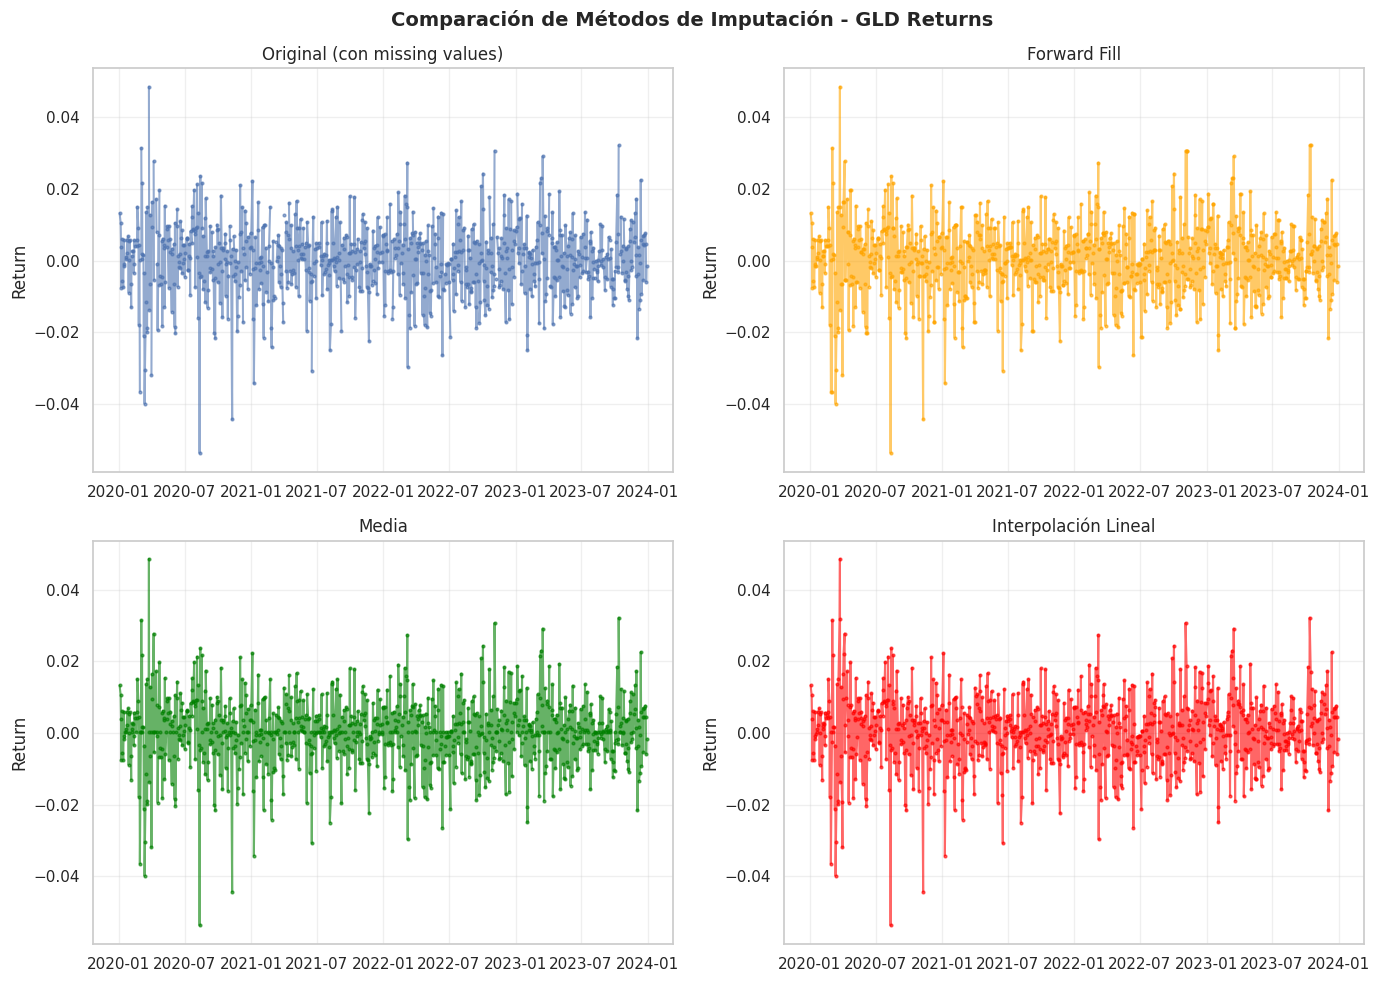


🎯 ¿CUÁL MÉTODO USAR?
----------------------------------------------------------------------
  Forward Fill (ffill):
    ✓ Bueno para series temporales con alta autocorrelación
    ✗ Puede introducir sesgo si hay tendencias

  Media:
    ✓ Simple y no introduce tendencias artificiales
    ✗ Puede subestimar volatilidad

  Mediana:
    ✓ Robusto a outliers
    ✗ Similar a media, reduce variabilidad

  Interpolación:
    ✓ Suave, mantiene tendencias locales
    ✗ Puede crear valores irreales en volatilidad alta

  💡 RECOMENDACIÓN para retornos financieros:
     → Interpolación o Forward Fill
     → Evitar media/mediana (reducen volatilidad)


In [ ]:
print("\n" + "="*70)
print("EJERCICIO 15: Missing Data e Imputación")
print("="*70)

# Trabajar con una copia de retornos de GLD
gld_data = returns[['GLD']].dropna().copy()
gld_data.reset_index(inplace=True)
gld_data.columns = ['date', 'ret']

print(f"\n📊 Datos originales: {len(gld_data)} observaciones")
print(f"   Missing values: {gld_data['ret'].isna().sum()}")

# Crear missing data artificialmente (10% aleatorio)
np.random.seed(42)
n_missing = int(len(gld_data) * 0.10)
missing_indices = np.random.choice(gld_data.index, n_missing, replace=False)
gld_data.loc[missing_indices, 'ret'] = np.nan

print(f"\n🔴 Después de crear NaN: {gld_data['ret'].isna().sum()} missing values ({gld_data['ret'].isna().sum() / len(gld_data) * 100:.1f}%)")

# ========== MÉTODOS DE IMPUTACIÓN ==========

# 1. Forward Fill (usar valor anterior)
gld_data['ret_ffill'] = gld_data['ret'].ffill()

# 2. Media
gld_data['ret_mean'] = gld_data['ret'].fillna(gld_data['ret'].mean())

# 3. Mediana
gld_data['ret_median'] = gld_data['ret'].fillna(gld_data['ret'].median())

# 4. Interpolación lineal
gld_data['ret_interp'] = gld_data['ret'].interpolate(method='linear')

print("\n✅ MÉTODOS DE IMPUTACIÓN APLICADOS:")
print("-" * 70)
print(f"  1. Forward Fill  - Usa el valor anterior")
print(f"  2. Media         - Reemplaza con promedio = {gld_data['ret'].mean():.6f}")
print(f"  3. Mediana       - Reemplaza con mediana = {gld_data['ret'].median():.6f}")
print(f"  4. Interpolación - Interpola linealmente entre valores")

# Mostrar ejemplo de imputación
ejemplo_idx = missing_indices[:5]
print(f"\n📋 EJEMPLO de imputación (primeros 5 valores missing):")
print(gld_data.loc[ejemplo_idx, ['date', 'ret', 'ret_ffill', 'ret_mean', 'ret_median', 'ret_interp']])

# Visualizar comparación
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparación de Métodos de Imputación - GLD Returns',
             fontsize=14, fontweight='bold')

# Original con missing
axes[0, 0].plot(gld_data['date'], gld_data['ret'],
                marker='o', markersize=2, alpha=0.6)
axes[0, 0].set_title('Original (con missing values)')
axes[0, 0].set_ylabel('Return')
axes[0, 0].grid(alpha=0.3)

# Forward Fill
axes[0, 1].plot(gld_data['date'], gld_data['ret_ffill'],
                marker='o', markersize=2, alpha=0.6, color='orange')
axes[0, 1].set_title('Forward Fill')
axes[0, 1].set_ylabel('Return')
axes[0, 1].grid(alpha=0.3)

# Media
axes[1, 0].plot(gld_data['date'], gld_data['ret_mean'],
                marker='o', markersize=2, alpha=0.6, color='green')
axes[1, 0].set_title('Media')
axes[1, 0].set_ylabel('Return')
axes[1, 0].grid(alpha=0.3)

# Interpolación
axes[1, 1].plot(gld_data['date'], gld_data['ret_interp'],
                marker='o', markersize=2, alpha=0.6, color='red')
axes[1, 1].set_title('Interpolación Lineal')
axes[1, 1].set_ylabel('Return')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎯 ¿CUÁL MÉTODO USAR?")
print("-" * 70)
print("  Forward Fill (ffill):")
print("    ✓ Bueno para series temporales con alta autocorrelación")
print("    ✗ Puede introducir sesgo si hay tendencias")
print("\n  Media:")
print("    ✓ Simple y no introduce tendencias artificiales")
print("    ✗ Puede subestimar volatilidad")
print("\n  Mediana:")
print("    ✓ Robusto a outliers")
print("    ✗ Similar a media, reduce variabilidad")
print("\n  Interpolación:")
print("    ✓ Suave, mantiene tendencias locales")
print("    ✗ Puede crear valores irreales en volatilidad alta")
print("\n  💡 RECOMENDACIÓN para retornos financieros:")
print("     → Interpolación o Forward Fill")
print("     → Evitar media/mediana (reducen volatilidad)")

16. Standardize a variable (z-score) and plot **before vs after**.  


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
tickers = ["SPY", "TLT"]

data = yf.download(tickers, start="2015-01-01", auto_adjust=True)["Close"]
data = data.dropna()

[*********************100%***********************]  2 of 2 completed


In [ ]:
#CALCULAMOS RETORNOS DIARIOS
returns = data.pct_change().dropna()
returns.columns = ["SPY_ret", "TLT_ret"]

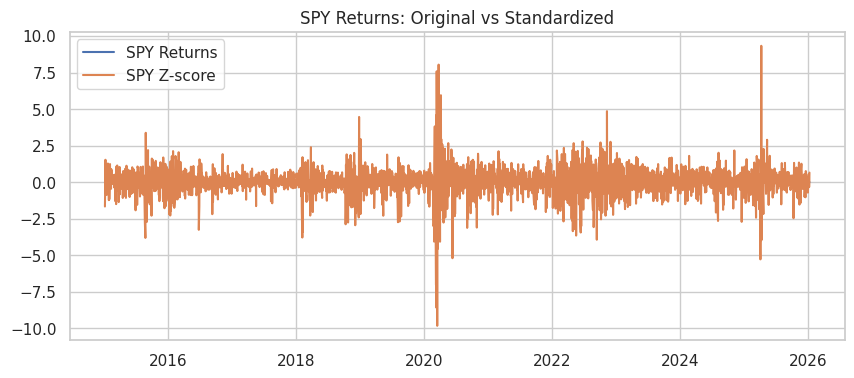

In [ ]:
#ESTANDARIZAMOS LA VARIABLE
#USAMOS SPY_ret
spy_mean = returns["SPY_ret"].mean()
spy_std = returns["SPY_ret"].std()

returns["SPY_z"] = (returns["SPY_ret"] - spy_mean) / spy_std

#PLOT ANTES Y DESPUES
plt.figure(figsize=(10,4))
plt.plot(returns["SPY_ret"], label="SPY Returns")
plt.plot(returns["SPY_z"], label="SPY Z-score")
plt.legend()
plt.title("SPY Returns: Original vs Standardized")
plt.show()

17. Find the day with the largest `|SPY_ret|` and **annotate it** in the returns plot (like the exercise).  


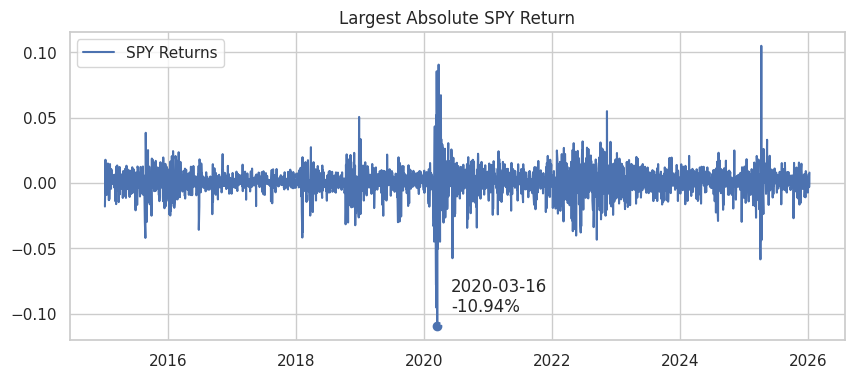

In [ ]:
#ENCONTRAMOS EL DIA CON EL MAYOR SPY_ret
max_day = returns["SPY_ret"].abs().idxmax()
max_value = returns.loc[max_day, "SPY_ret"]
#PLOT CON ANOTACION
plt.figure(figsize=(10,4))
plt.plot(returns["SPY_ret"], label="SPY Returns")
plt.scatter(max_day, max_value)
plt.annotate(
    f"{max_day.date()}\n{max_value:.2%}",
    (max_day, max_value),
    xytext=(10,10),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->")
)
plt.title("Largest Absolute SPY Return")
plt.legend()
plt.show()

18. Save one figure into `/figures` using `savefig` and verify the file exists.  


In [ ]:
#GUARDAR UNA FIGURA EN /FIGURES
os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(8,4))
returns["SPY_ret"].plot(title="SPY Daily Returns")
plt.savefig("figures/spy_returns.png")
plt.close()
#VERIFICAMOS QUE EXISTE
os.path.exists("figures/spy_returns.png")

True

19. Build a **summary stats table** for returns (mean, sd, p5, p95, etc.).  


In [ ]:
#CONSTRUIMOS LA TABLA
summary_stats = returns.agg(
    ["mean", "std",
     lambda x: x.quantile(0.05),
     lambda x: x.quantile(0.95)]
)

summary_stats.index = ["mean", "std", "p5", "p95"]
summary_stats

,SPY_ret,TLT_ret,SPY_z
mean,0.000570,0.000018,3.205263e-18
std,0.011198,0.009466,1.000000e+00
p5,-0.016727,-0.015062,-1.544627e+00
p95,0.015578,0.014727,1.340222e+00


20. Compute **historical 95% VaR** for a **60/40 portfolio (SPY/TLT)** and explain what it means.


In [ ]:
#CONSTRUIMOS RETORNOS DEL PORTAFOLIO
returns["portfolio"] = 0.6 * returns["SPY_ret"] + 0.4 * returns["TLT_ret"]
#CALCULAMOS EL VaR HISTÓRICO
var_95 = returns["portfolio"].quantile(0.05)
var_95

np.float64(-0.010950488624948941)